In [1]:
%reset -f dhist in   
import numpy as np
import os
from scipy import stats
from scipy.stats import reciprocal

%matplotlib inline
#%matplotlib widget
#%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}
mpl.rc('axes', labelsize=24)
mpl.rc('xtick', labelsize=24)
mpl.rc('ytick', labelsize=24)
plt.rc('font', **font)

# ML related libraries
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from sklearn.neighbors import NearestNeighbors

from ase.io.xyz import read_xyz
from ase.io.xyz import write_xyz
from ase.io import read
from ase.build import molecule
from ase import Atoms

from dscribe.descriptors import SOAP
from dscribe.descriptors import SOAP
from dscribe.kernels import AverageKernel
from dscribe.kernels import REMatchKernel


# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, fig_id + ".png")
    print("Saving figure....", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    print("Figure saved!")

Flushing directory history
Flushing input history


In [2]:
#location = "Al-1Sc_950K/Local_Vectors_perConfig/"
#fileName = "LV.1000"

#filePath = location+fileName+".csv"

#filePath = 'Al-1Sc_950K/DATA/POSCAR.'+ str(fileIndex)

#pddata = pd.read_csv(filePath)
#X = pddata.to_numpy()

#X_dr = X[:,1:31]
#X_dr.shape

In [3]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("coolwarm")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

In [4]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=50, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=150)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".",s=150)
    if show_xlabels:
        #plt.xlabel("$x_1$", fontsize=24)
        plt.xlabel("$1^{st}$ t-SNE eigen vector",weight="bold")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        #plt.ylabel("$x_2$", fontsize=24, rotation=90)
        plt.ylabel("$2^{nd}$ t-SNE eigen vector",weight="bold")
    else:
        plt.tick_params(labelleft=False)
    #plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)
    
    
def plot_dbscan_w_clusters(ax,dbscan, X, size, show_xlabels=True, show_ylabels=True,plot_anomalies=1):
    
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    clust = dbscan.labels_
    mx=max(clust)
    cMap = mpl.cm.get_cmap('Paired')
    for i in range(mx+1):
        x=X[:,0][np.where(clust==i)]
        y=X[:,1][np.where(clust==i)]

        ax.scatter(x,y,color=cMap(i/mx),cmap='Paired',label='Cluster: '+str(i),s=size,marker='o')
        
        
    ax.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    if plot_anomalies==1:
        ax.scatter(anomalies[:, 0], anomalies[:, 1],c="r", marker="x", s=100)
    ax.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".",s=150)
    if show_xlabels:
        ax.set_xlabel("$x_1$", fontsize=24)
    else:
        ax.tick_params(labelbottom=False)
    if show_ylabels:
        ax.set_ylabel("$x_2$", fontsize=24, rotation=0)
    else:
        ax.tick_params(labelleft=False)
    ax.set_title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',fontsize=24)
    plt.tight_layout()    

In [5]:
def get_local_feature_vector(fileIndex, rcut, nmax, lmax, njobs):
    
    fileName_main = 'POSCAR_'+ str(fileIndex)
    
    #fileName_main = '0p3_Sc/POSCAR_'+ str(fileIndex) # For homogeneous nucleation
    #fileName_main = '0p3_Sc/dynamics/POSCAR_0'
    #fileName_main = '1_Sc/POSCAR_'+ str(fileIndex) # For homogeneous nucleation
    #fileName_main = '8_Sc/POSCAR_'+ str(fileIndex) # For homogeneous nucleation
    #fileName_main = 'Hetero/melt/POSCAR_'+ str(fileIndex) # For heterogenous nucleation
    #fileName_main = 'Hetero/POSCAR_'+ str(fileIndex) # For heterogenous nucleation
    #fileName_main = 'pure-Al/POSCAR_'+ str(fileIndex) 
    
    mainStructure = read(fileName_main)
    mainStructureSpecies = set()
    mainStructureSpecies.update(mainStructure.get_chemical_symbols())
    
    soap = SOAP(
        species=mainStructureSpecies,
        periodic=True,
        rcut=rcut,
        nmax=nmax,
        lmax=lmax,
        sparse=False
    )
    
    feature_vectors = soap.create(mainStructure, n_jobs=njobs)
    return feature_vectors

In [6]:
def get_local_feature_vector2(fileName_main, rcut, nmax, lmax, njobs):
   
    mainStructure = read(fileName_main)
    mainStructureSpecies = set()
    mainStructureSpecies.update(mainStructure.get_chemical_symbols())
    
    soap = SOAP(
        species=mainStructureSpecies,
        periodic=True,
        rcut=rcut,
        nmax=nmax,
        lmax=lmax,
        sparse=False,
        weighting={"function": 'poly', "r0": rcut, "m": 2, "c": 1, "d": 1},
    )
    
    feature_vectors = soap.create(mainStructure, n_jobs=njobs)
    return feature_vectors

In [7]:
def get_2D_X_reduced(eigen_vector_algo, X_vec):
    if eigen_vector_algo == "t-sne" or eigen_vector_algo == "T-SNE" or eigen_vector_algo == "t-SNE":
        print("Using t-SNE...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=15, n_iter=1000, learning_rate='auto', init='random')#learning_rate=200)
        print(tsne.get_params())
        X_reduced = tsne.fit_transform(X_vec)
        X_reduced = scaler.fit_transform(X_reduced)
    elif eigen_vector_algo == "kernel-PCA":
        print("Using Kernel PCA...")
        kpca = KernelPCA(n_components=2,kernel="rbf",gamma=0.1)
        X_reduced = kpca.fit_transform(X_vec)
    elif eigen_vector_algo == "PCA":
        pca = PCA(n_components=2)
        X_reduced = pca.fit_transform(X_vec)
        
    return X_reduced    

Vector shape (92, 180)
Using t-SNE...
{'angle': 0.5, 'early_exaggeration': 12.0, 'init': 'random', 'learning_rate': 'auto', 'method': 'barnes_hut', 'metric': 'euclidean', 'metric_params': None, 'min_grad_norm': 1e-07, 'n_components': 2, 'n_iter': 1000, 'n_iter_without_progress': 300, 'n_jobs': None, 'perplexity': 15, 'random_state': 42, 'square_distances': 'deprecated', 'verbose': 0}
(92, 2)


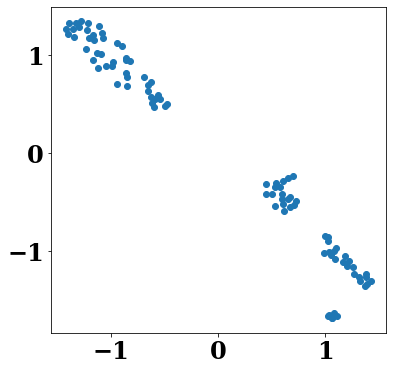

In [23]:
scaler = StandardScaler()

# Parameters used for responding to reviewers questions

#fileName_main = '0p3_Sc/1450K_anneal/POSCAR_800' # For homogeneous nucleation EPS = 0.33
#X_vec = get_local_feature_vector2(fileName_main,10, 7, 7, -1) # good for 1500 EPS = 0.33
#X_vec = get_local_feature_vector2(fileName_main,20, 8, 8, -1) # also good for 1100 - 1500 EPS = 0.33
#X_vec = get_local_feature_vector2(fileName_main,20, 8, 8, -1) # also good for 800 EPS = 0.32
#X_vec = get_local_feature_vector2(fileName_main,20, 8, 8, -1) 


#X_vec = get_local_feature_vector(913, 10, 7, 7, -1)# Good for atom collection surrounded by 'vacuum'
#X_vec = get_local_feature_vector(2000,7.2, 6, 6, -1)
#X_vec = get_local_feature_vector(2000,4.1, 6, 6, -1) # Only for hetero nucleationn
#X_vec = get_local_feature_vector(2500,10, 6, 6, -1) # Only for hetero nucleationn

#fileName_main = '0p3_Sc/1450K_anneal/POSCAR_0' # For homogeneous nucleation EPS = 0.33
#fileName_main = 'pure-Al/POSCAR_800' # For homogeneous nucleation EPS = 0.33
#X_vec = get_local_feature_vector(fileName_main,12, 7, 7, -1)

#fileName_main = '0p3_Sc/dynamics/POSCAR_0' # For homogeneous nucleation EPS = 0.33
#X_vec = get_local_feature_vector2(fileName_main,12, 6, 6, -1)
#X_vec = get_local_feature_vector(800, 10, , 7, -1)

#fileName_main = '1_Sc/POSCAR_0'# For homogeneous nucleation EPS = 0.28
#X_vec = get_local_feature_vector2(fileName_main,12, 12, 12, -1)

#fileName_main = 'Hetero/POSCAR_0' # For heterogenous nucleation

fileName_main = 'poscar/POSCAR_66'
X_vec = get_local_feature_vector2(fileName_main,12, 4, 4, -1)

print("Vector shape",X_vec.shape)

X_reduced = get_2D_X_reduced("t-sne", X_vec)
X_reduced = scaler.fit_transform(X_reduced)

print(X_reduced.shape)

plt.figure(figsize=(6, 6))
plt.scatter(X_reduced[:,0],X_reduced[:,1])

In [24]:
X_vec

array([[ 0.61381121,  2.60472216,  2.85507293, ...,  2.53019393,
         1.55597955,  1.00719026],
       [ 0.62973533,  2.10653681,  4.89010328, ...,  1.31189066,
         0.89353666,  0.72046527],
       [ 0.59516722,  2.11709378,  5.75062268, ...,  1.04101126,
         1.23306527,  1.54171287],
       ...,
       [ 0.0531735 , -0.92170358,  1.31820177, ...,  0.02951765,
        -0.16771526,  1.07157277],
       [ 0.04823879, -0.89978672,  1.10498329, ...,  0.04579808,
        -0.15725615,  0.72199579],
       [ 0.06160932, -1.04703407,  1.2767647 , ...,  0.05616432,
        -0.13950855,  0.72309647]])

(92, 6)
(92, 6)


Text(0, 0.5, 'Euclidean distance, $\\epsilon$')

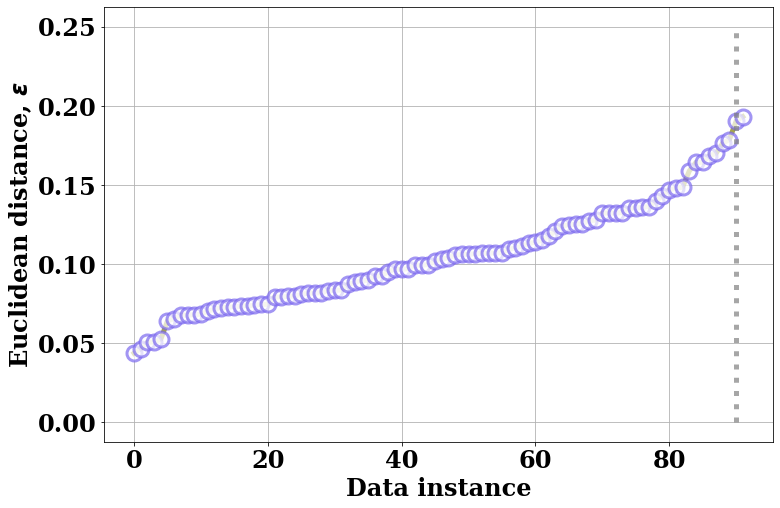

In [25]:
neighbours = NearestNeighbors(n_neighbors=6)
neighbours_fit = neighbours.fit(X_reduced)
distances, indices = neighbours_fit.kneighbors(X_reduced)

print(distances.shape)

distances = np.sort(distances,axis=0)
print(distances.shape)

plt.figure(figsize=(12, 8))
#plt.plot(distances[:,1])
#plt.plot(distances[:,2])
#plt.plot(distances[:,3])
#plt.plot(distances[:,4])

#plt.vlines(384,0,0.5, color = "gray", linewidth=5, alpha=0.7)
#plt.vlines(366,0,0.5, color = "gray", linewidth=5, alpha=0.7,linestyles="dotted")

plt.plot(distances[:,4],"o-",color = "olive",markersize=15,   # Divide by 10 to connvert from Ang to nannometers
         markerfacecolor="white", markeredgecolor="mediumslateblue", alpha=0.7,
         markeredgewidth=3, label="8at.% Sc", linewidth=5)
#plt.plot(distances[:,5])


#plt.hlines(0.26,0,250, color = "gray", linewidth=5, alpha=0.7)
plt.vlines(90,0,0.25, color = "gray", linewidth=5, alpha=0.7,linestyles="dotted")


plt.grid('true')
plt.xlabel(r'Data instance' , fontsize=24, weight="bold")
plt.ylabel(r'Euclidean distance, $\epsilon$', fontsize=24, weight="bold")
#plt.ylim(0.0,np.max(distances[:,4]))

[0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 2 1 0 2 1 2 0 2 2 0 1 2 1 2 1 2 1 2 1
 2 0 2 1 2 2 0 0 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 1 1 1
 1 2 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3]


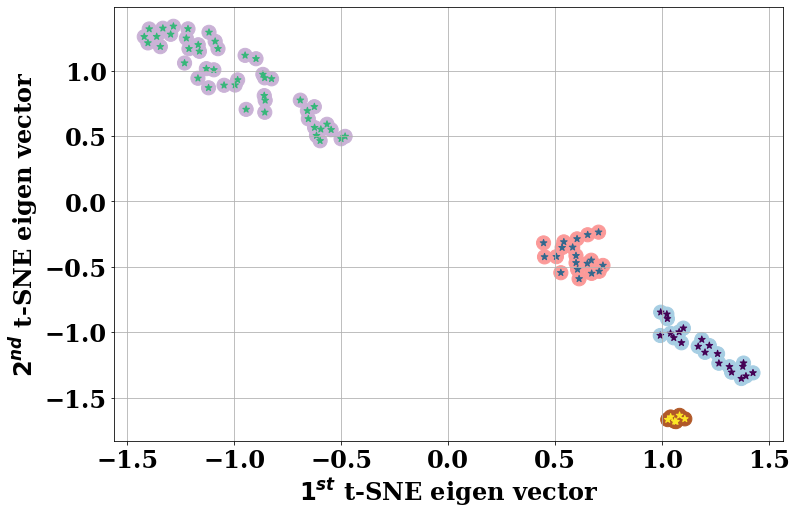

In [26]:
# For 10th step EPS = 0.28 is good use two clusters with values 23 and 7; total 30

#EPS = 0.2 ## Good for homogennous nucleation

EPS = 0.25 ## Good for heterogenneous nucleation

dbscan = DBSCAN(eps=EPS, min_samples=6)
dbscan.fit(X_reduced)
print(dbscan.labels_)

#plt.figure(figsize=(8, 8))
plt.figure(figsize=(12,8))

plot_dbscan(dbscan, X_reduced, size=200)
plt.grid('true')

#print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_reduced, dbscan.labels_))

len(dbscan_tsne.core_sample_indices_)
labels = dbscan_tsne.labels_
len(labels[labels[:]==1])

dbscan.get_params()

fig,ax = plt.subplots(figsize=(12, 6))
plot_dbscan_w_clusters(ax,dbscan, X_reduced, size=200)

In [11]:
#dbscan_tsne = DBSCAN(eps=EPS, min_samples=5)
#dbscan_tsne.fit(X_reduced_tsne)
clusters = dbscan.labels_
for i in range(15):
    print("i=",i,"No. of atoms ",len(clusters[clusters[:]==i]))

i= 0 No. of atoms  22
i= 1 No. of atoms  19
i= 2 No. of atoms  45
i= 3 No. of atoms  6
i= 4 No. of atoms  0
i= 5 No. of atoms  0
i= 6 No. of atoms  0
i= 7 No. of atoms  0
i= 8 No. of atoms  0
i= 9 No. of atoms  0
i= 10 No. of atoms  0
i= 11 No. of atoms  0
i= 12 No. of atoms  0
i= 13 No. of atoms  0
i= 14 No. of atoms  0


In [12]:
indices = np.where(clusters==0)
#print(indices)
a = indices[0]
#print(a)
for i in range(len(a)):
    print("|| ParticleIndex == ",a[i])

|| ParticleIndex ==  0
|| ParticleIndex ==  1
|| ParticleIndex ==  2
|| ParticleIndex ==  4
|| ParticleIndex ==  5
|| ParticleIndex ==  6
|| ParticleIndex ==  7
|| ParticleIndex ==  9
|| ParticleIndex ==  10
|| ParticleIndex ==  12
|| ParticleIndex ==  13
|| ParticleIndex ==  14
|| ParticleIndex ==  15
|| ParticleIndex ==  16
|| ParticleIndex ==  17
|| ParticleIndex ==  20
|| ParticleIndex ==  24
|| ParticleIndex ==  27
|| ParticleIndex ==  38
|| ParticleIndex ==  43
|| ParticleIndex ==  44
|| ParticleIndex ==  62
